# Weighted ECM clustering vs Traditional ECM clustering
## LettersIJL dataset

In [50]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot, calculate_non_specificity, plotting
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from evclust.datasets import load_letters


     A    B    C    D    E    F    G    H    I     J    K    L    M    N    O  \
0  3.0  7.0  3.0  5.0  1.0  1.0  1.0  5.0  5.0   0.0  1.0  6.0  0.0  8.0  0.0   
1  3.0  4.0  4.0  7.0  1.0  0.0  1.0  6.0  6.0   0.0  0.0  6.0  0.0  8.0  0.0   
2  0.0  0.0  0.0  1.0  0.0  7.0  7.0  4.0  4.0   7.0  6.0  8.0  0.0  8.0  0.0   
3  1.0  4.0  2.0  3.0  1.0  9.0  6.0  2.0  6.0  12.0  4.0  9.0  1.0  7.0  1.0   
4  1.0  7.0  0.0  4.0  0.0  7.0  7.0  4.0  4.0   7.0  6.0  8.0  0.0  8.0  0.0   

     P  
0  8.0  
1  8.0  
2  8.0  
3  7.0  
4  8.0  


D:\vtdo\projects\evclust\src\evclust\utils.py:1085: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


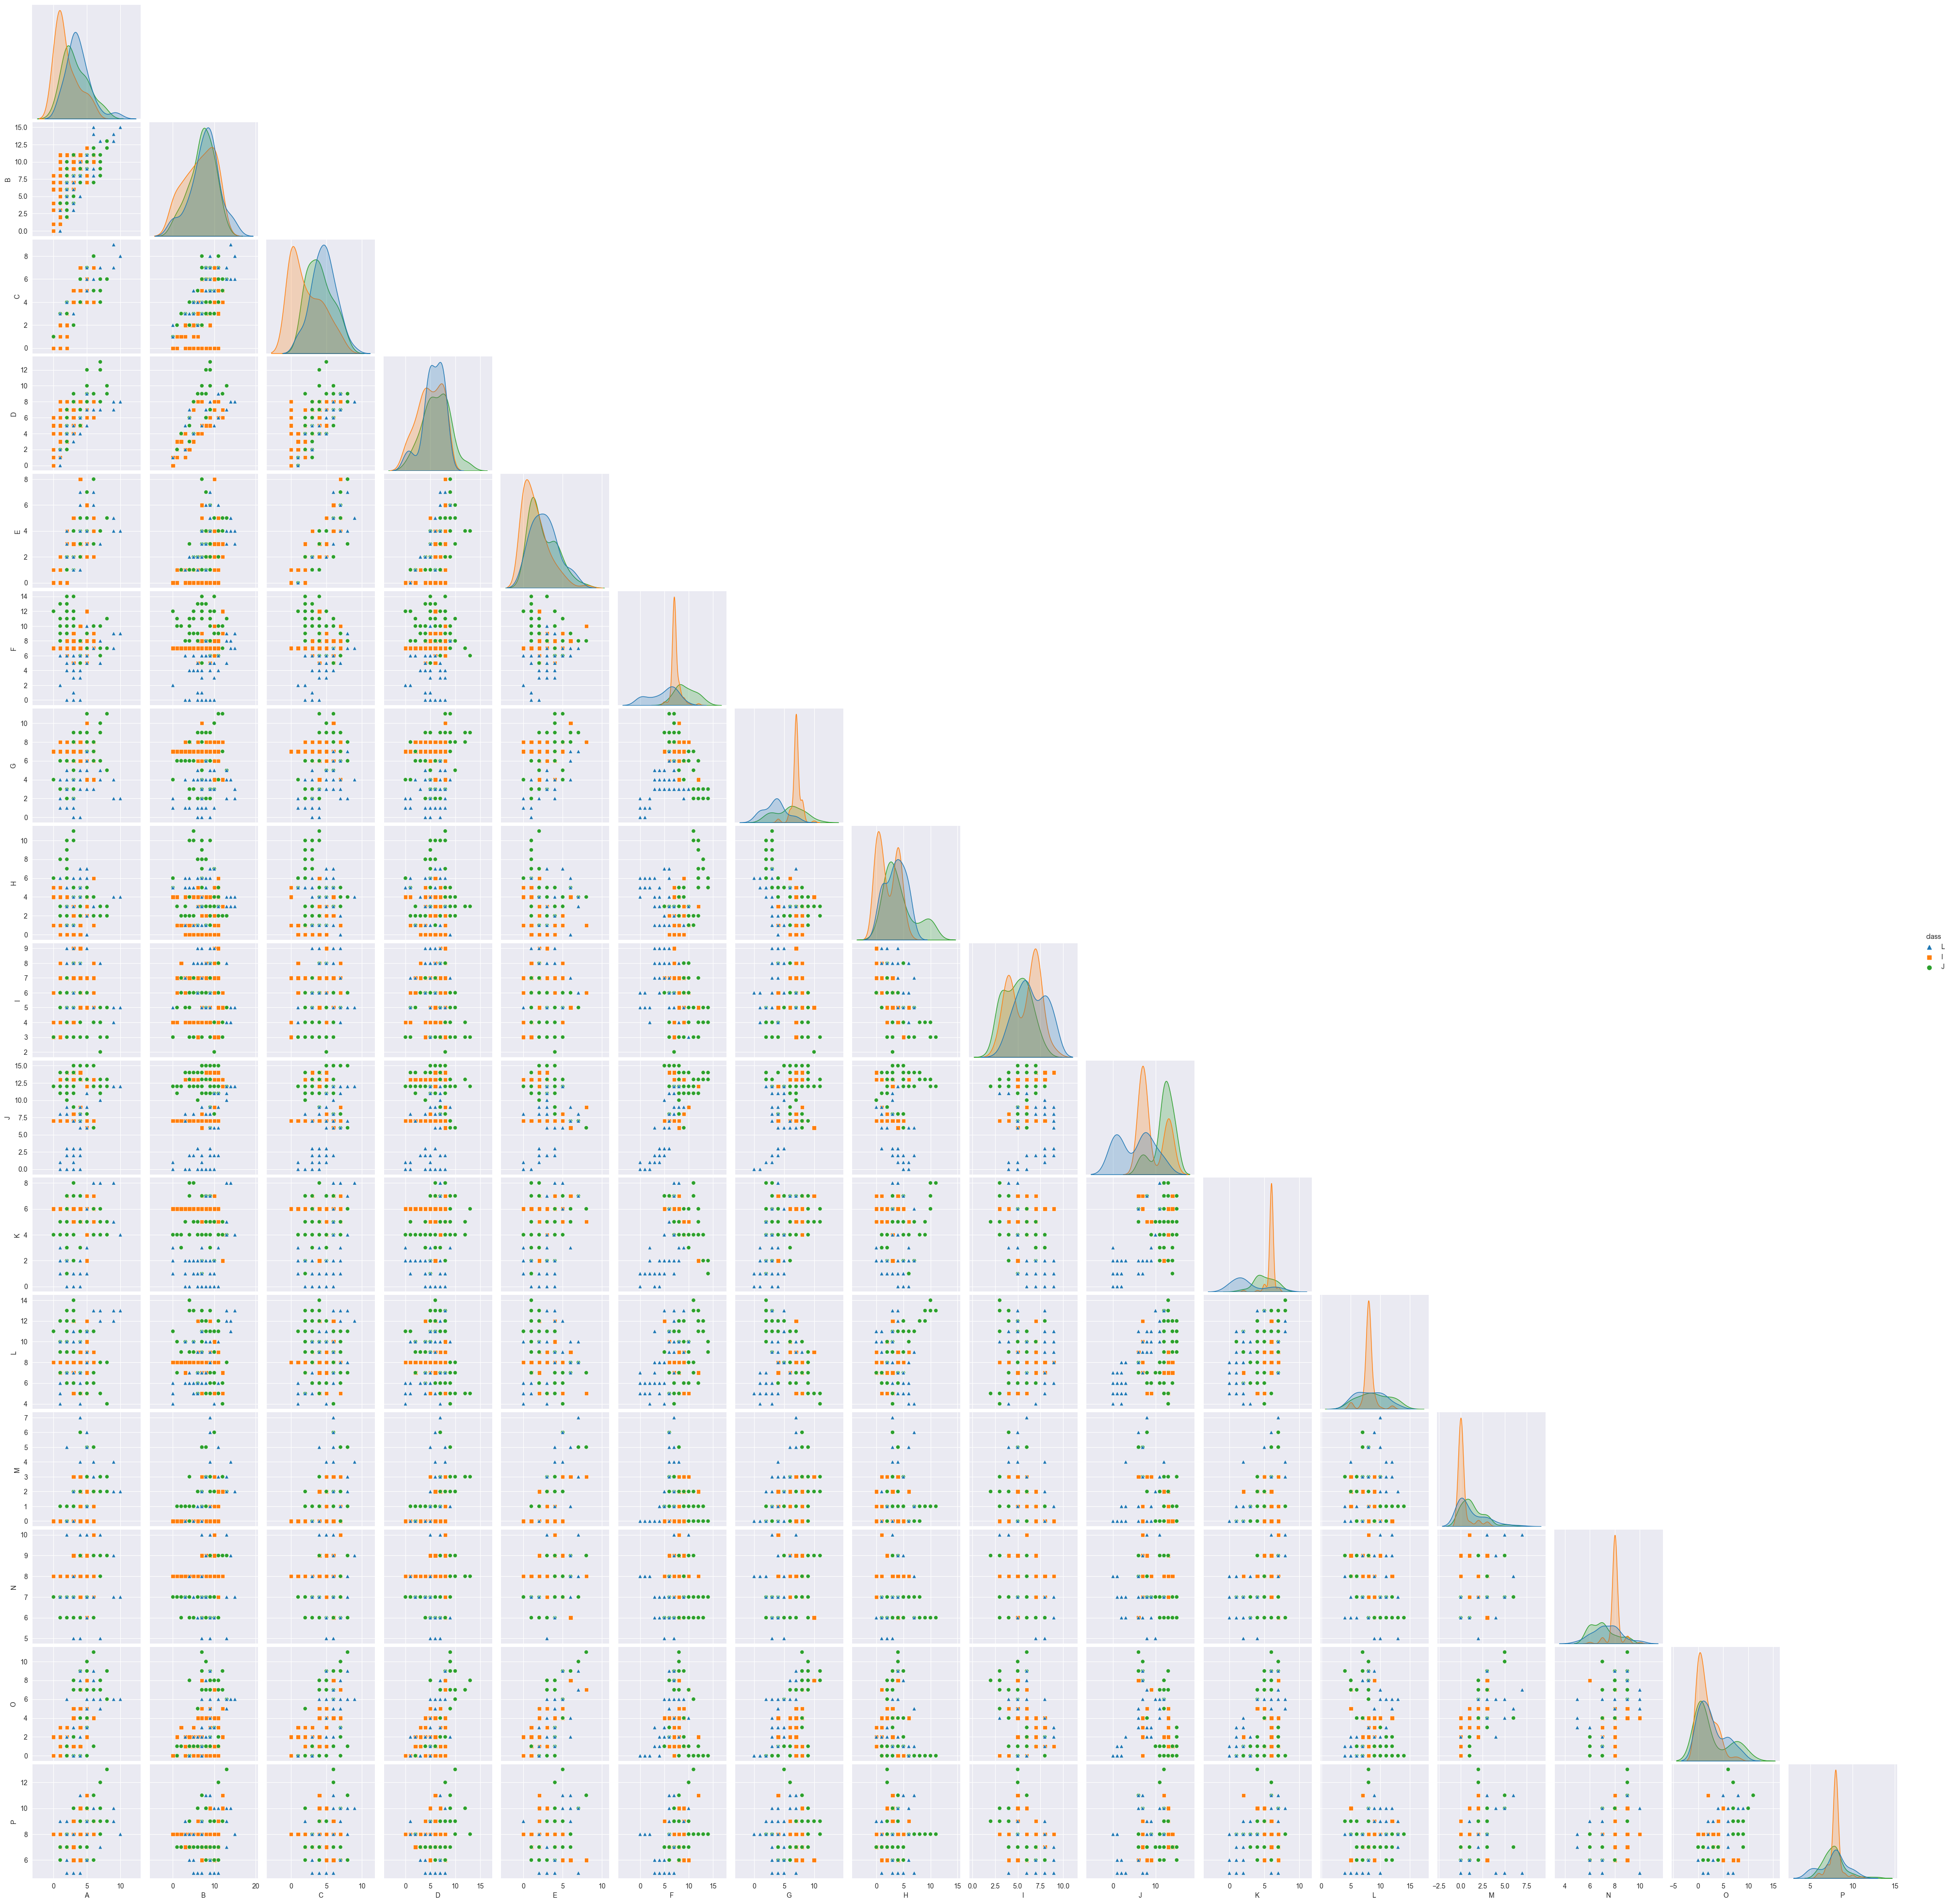

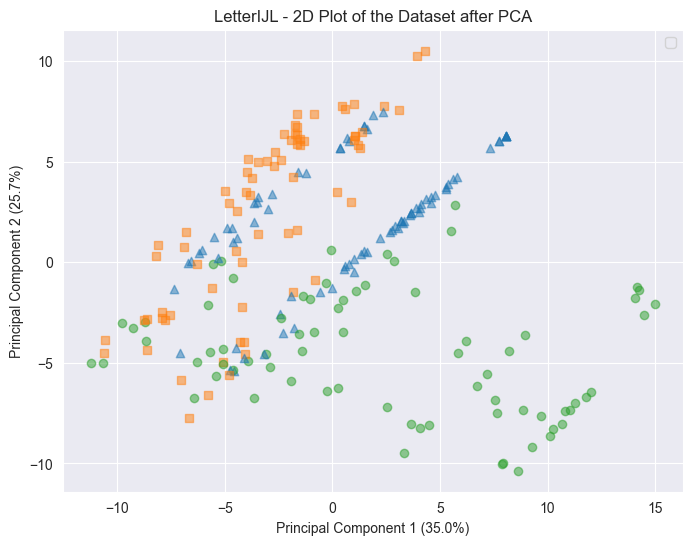

In [51]:
# fetch dataset
df = load_letters()

# data (as pandas dataframes)
y = pd.DataFrame(df.iloc[:, -1])
X = df.iloc[:, :-1]

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, "LetterIJL", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler((0, 1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

[1, 36.92964638719912]
[2, 36.189464241678856]
[3, 36.03882111940572]
[4, 35.9660174398098]
[5, 35.919167971957464]
[6, 35.8842717518692]
[7, 35.856348020783415]
[8, 35.83328762216343]
[9, 35.81403623940079]
[10, 35.79796234171132]
[11, 35.78461412407809]
[12, 35.77362168814776]
[13, 35.76465815935489]
[14, 35.75742566854168]
[15, 35.751651753448826]
[16, 35.74708974989069]
[17, 35.7435201791512]
[18, 35.740751711475795]
[19, 35.73862110403906]
[20, 35.736991997591595]
[21, 35.73575274663035]
[22, 35.73481359982617]
[1, 36.929646387199114]
[2, 36.189464241678856]
[3, 36.038821119405725]
[4, 35.9660174398098]
[5, 35.91916797195746]
[6, 35.8842717518692]
[7, 35.85634802078341]
[8, 35.83328762216343]
[9, 35.81403623940079]
[10, 35.79796234171132]
[11, 35.78461412407809]
[12, 35.77362168814776]
[13, 35.76465815935489]
[14, 35.75742566854167]
[15, 35.75165175344883]
[16, 35.74708974989069]
[17, 35.7435201791512]
[18, 35.74075171147579]
[19, 35.738621104039055]
[20, 35.73699199759159]
[21, 3

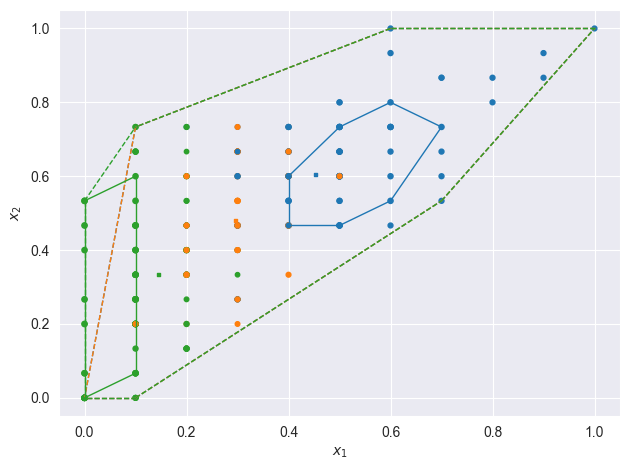

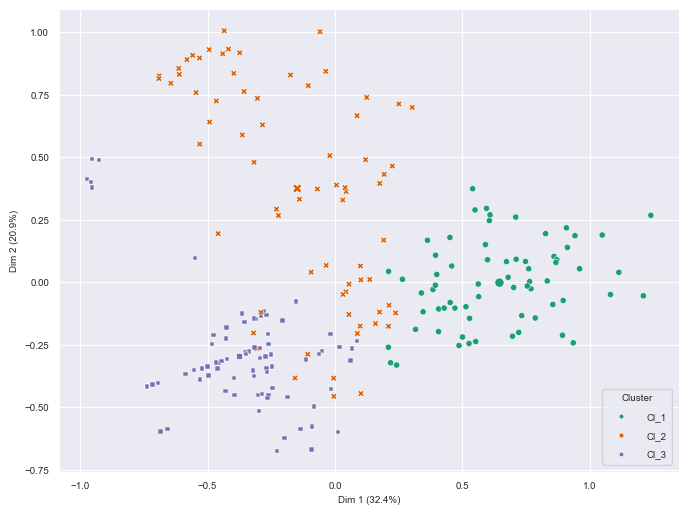

In [52]:
# Traditional ECM clustering
delta = np.sqrt(20)
model_list = np.array([])
for i in range(10):
    model = ecm(x=X, c=3, beta=2, alpha=1, delta=delta, epsi=1e-3, ntrials=1, init="kmeans")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda x: x['crit'])
# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

# Plotting the model with the minimum J value
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

## Weighted ECM (WECM)

In [56]:
%%capture
# Weighted ECM clustering
model_list = np.array([])
c = 3
d = X.shape[1]
for i in range(10):
    W = np.ones((c, d)) * (1 / d)
    delta = np.sqrt(20)
    model = wecm(x=X, c=c, W=W, beta=2, alpha=1, delta=delta, epsi=1e-3, ntrials=1, init="kmeans", stopping_factor="center")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda model: model['crit'])
# Weights
top_weights = [model['W'] for model in model_list]

# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

In [57]:

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

J values: [0.1045897220782359, 0.10493512731419757, 0.10493512731419757, 0.10493512731419759, 0.10493512731419759, 0.10493512731419759, 0.10493512731419759, 0.10493512731419759, 0.1049351273141976, 0.10494539015432722]
ARI values: [0.2118143098953773, 0.24204083777725066, 0.24204083777725066, 0.24204083777725066, 0.24204083777725066, 0.24204083777725066, 0.24204083777725066, 0.24204083777725066, 0.24204083777725066, 0.2317449514543153]
NS values: [1.3012108124470727, 1.3031702259620375, 1.3031702259620375, 1.320994411039575, 1.320994411039575, 1.3740939226917637, 1.3693912565739434, 1.3740939226917637, 1.2419613700231307, 1.2646627299131903]
NMI values: [0.20147387417962137, 0.23611591366114465, 0.23611591366114465, 0.23611591366114465, 0.23611591366114465, 0.23611591366114465, 0.23611591366114465, 0.23611591366114465, 0.2361159136611446, 0.22334540501059205]
Average ARI values: 0.23798859635676978
Average Non-specificity: 1.317374328834409
Average Normalized mutual infor: 0.2313746588

In [58]:
for W in top_weights:
    print(f"\n{W}")


[[0.12364077 0.06068207 0.08498784 0.09514712 0.10279715 0.01187082
  0.04084352 0.02306428 0.02826502 0.00953233 0.01486457 0.02176676
  0.13388962 0.05372158 0.10221131 0.09271523]
 [0.07921493 0.01223533 0.03245618 0.01889921 0.07580437 0.07408965
  0.06144367 0.02424408 0.01492298 0.02032602 0.04268892 0.07042597
  0.14937598 0.0823814  0.07878022 0.16271109]
 [0.07428081 0.08539816 0.07925465 0.11349071 0.04957553 0.13511657
  0.05744497 0.09476434 0.05078597 0.04980944 0.05331102 0.03933218
  0.02741958 0.03114127 0.02540046 0.03347434]]

[[0.12225086 0.06066543 0.08404412 0.09459416 0.10176713 0.01216539
  0.04163084 0.02416927 0.02895881 0.00968257 0.01525014 0.02256804
  0.13268443 0.05481024 0.1017022  0.09305639]
 [0.0795915  0.01271728 0.0328788  0.01995243 0.07603468 0.07490505
  0.06219205 0.0245226  0.01519307 0.02064977 0.04328627 0.07013941
  0.14697909 0.08130364 0.07927098 0.16038337]
 [0.07437047 0.08512362 0.07852953 0.11228441 0.0496069  0.1334315
  0.0577885  0.